In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from SyntheticDataModule import *
from estimators import *
from utils import *

,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,1,500,1.860627,1.819871,1.817641,1.613285,3.056309,2.981116,3.005601,3.556473,1.195682,1.161245,1.187960,1.943188
1,1,1,2000,2.016929,1.998004,2.068221,2.113762,3.179639,2.750606,3.030133,3.164944,1.162710,0.752601,0.961912,1.051182


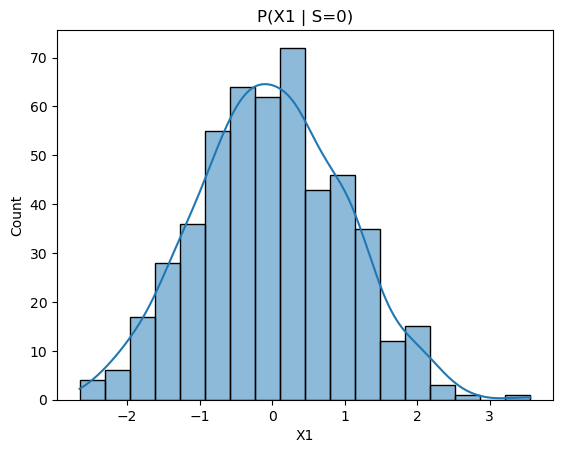

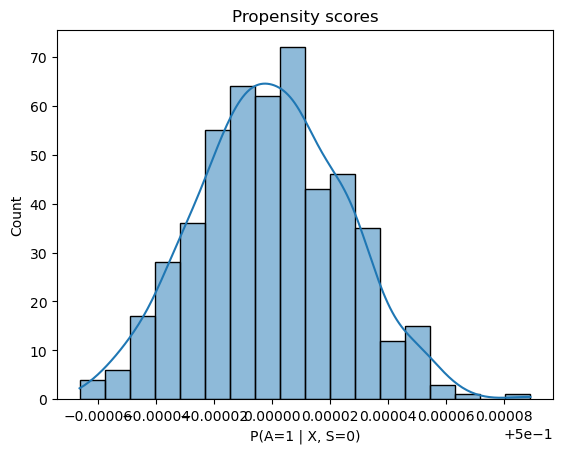

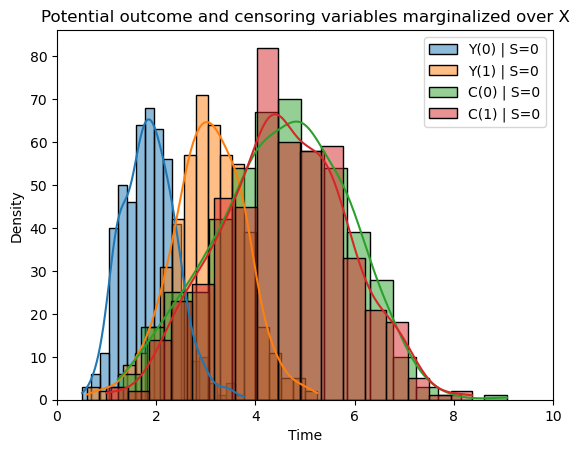

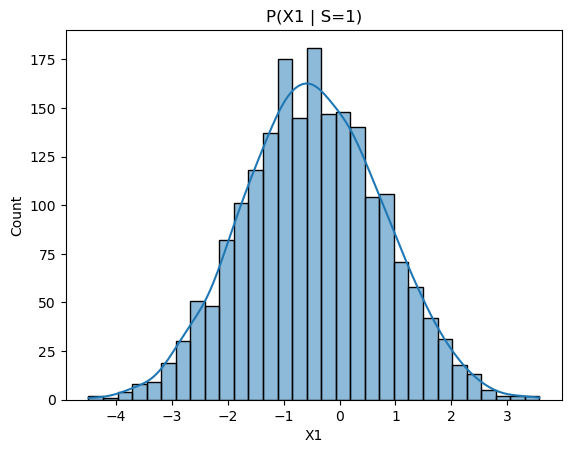

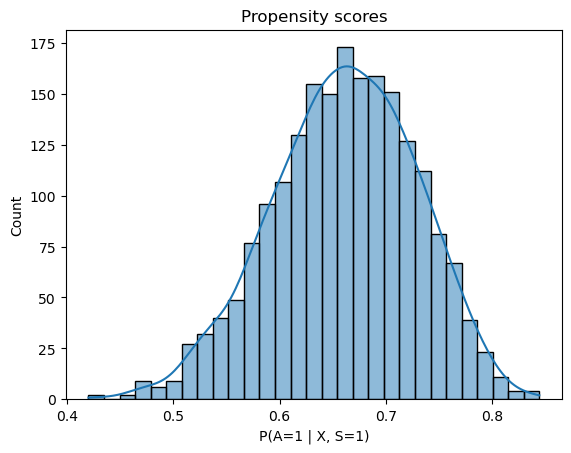

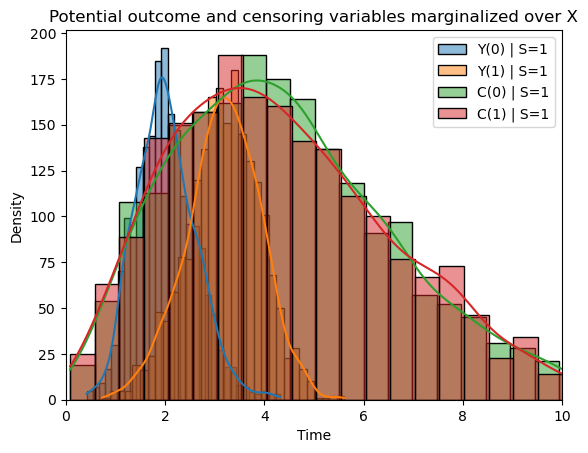

In [2]:
save_df = True
d = 1
rct_size = 500
m = 4
obs_size = rct_size * m

# RCT data generating model parameters

px_dist_r, px_args_r = 'Gaussian', {'mean': [0], 'cov': [[1]]}
prop_fn_r, prop_args_r = 'sigmoid', {'beta': [0, 1e-4]}
tte_params_r = {'model': 'coxph',
                'hazard': 'weibull',
                'cox_args': {'Y0': {'beta': [0,0.75], 'lambda': 0.5, 'p': 5},
                            'Y1': {'beta': [0,0.25], 'lambda': 0.3, 'p': 5},
                            'C0': {'beta': [0,0], 'lambda': 0.2, 'p': 4},
                            'C1': {'beta': [0,0], 'lambda': 0.2, 'p': 4},},
                }

# OBS data generating model parameters

px_dist_o, px_args_o = 'Gaussian', {'mean': [-0.5], 'cov': [[1.5]]}
prop_fn_o, prop_args_o = 'sigmoid', {'beta': [0.8, 0.25]}
tte_params_o = {'model': 'coxph',
                'hazard': 'weibull',
                'cox_args': {'Y0': {'beta': [0,0.75], 'lambda': 0.5, 'p': 5},
                            'Y1': {'beta': [0,0.25], 'lambda': 0.3, 'p': 5},
                            'C0': {'beta': [0,0], 'lambda': 0.2, 'p': 2},
                            'C1': {'beta': [0,0], 'lambda': 0.2, 'p': 2},},
                }

RCTData = SyntheticDataModule(save_df, d, rct_size, 0, px_dist_r, px_args_r, prop_fn_r, prop_args_r, tte_params_r)
OBSData = SyntheticDataModule(save_df, d, obs_size, 1, px_dist_o, px_args_o, prop_fn_o, prop_args_o, tte_params_o)

summary_df = pd.concat([RCTData.summary(plot=True), OBSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [3]:
# df_rct_oracle, df_rct = RCTData.get_df()
# df_obs_oracle, df_obs = OBSData.get_df()

# df_combined = pd.concat([df_rct, df_obs], axis=0, ignore_index=True)  # merge the dataframes into one
# cov_list = RCTData.get_covs()

# df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', cov_list, 'logistic')

# df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', cov_list, 'logistic')
# df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', cov_list, 'logistic')

# gc_est(df_combined, cov_list, tte_model='coxph')

# ipcw_est(df_combined, S=0)
# ipcw_est(df_combined, S=1)

# df_combined

In [4]:
save_df = False
B = 100  # num. samples to model the null distribution in every single run

num_exp = 50
m_arr = [1, 2, 3, 4, 5]  # multiplier to get the observational study size.
#m_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # multiplier to get the observational study size.
test_signals = {'IPCW-Contrast': ['S0_ipcw_est_CATE', 'S1_ipcw_est_CATE'],
                'IPCW-Y1': ['S0_ipcw_est_Y1', 'S1_ipcw_est_Y1'],
                'IPCW-Y0': ['S0_ipcw_est_Y0', 'S1_ipcw_est_Y0'],
                'Impute-IPW-Contrast': ['S0_impute_ipw_est_Y0', 'S1_impute_ipw_est_Y0'],
                'Impute-IPW-Y1': ['S0_impute_ipw_est_Y0', 'S1_impute_ipw_est_Y0'],
                'Impute-IPW-Y0': ['S0_impute_ipw_est_Y0', 'S1_impute_ipw_est_Y0'],}

mmr_results = np.zeros((len(test_signals), len(m_arr), num_exp))
mmr_pvals = np.zeros((len(test_signals), len(m_arr), num_exp))

m_cols = ['m = ' + str(m) for m in m_arr]
mmr_results_df = pd.DataFrame(columns=['Test'] + m_cols, index=range(len(test_signals)))

for mind, m in enumerate(m_arr):
    obs_size = rct_size * m 

    for nind in tqdm(range(num_exp)):
        RCTData = SyntheticDataModule(save_df, d, rct_size, 0, px_dist_r, px_args_r, prop_fn_r, prop_args_r, tte_params_r)
        OBSData = SyntheticDataModule(save_df, d, obs_size, 1, px_dist_o, px_args_o, prop_fn_o, prop_args_o, tte_params_o)

        df_rct_oracle, df_rct = RCTData.get_df()
        df_obs_oracle, df_obs = OBSData.get_df()

        df_combined = pd.concat([df_rct, df_obs], axis=0, ignore_index=True)  # merge the dataframes into one
        cov_list = RCTData.get_covs()

        # Estimate the nuisance parameters

        df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', cov_list, 'logistic')

        df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', cov_list, 'logistic')
        df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', cov_list, 'logistic')

        gc_est(df_combined, cov_list, tte_model='coxph')

        ipcw_est(df_combined, S=0)
        ipcw_est(df_combined, S=1)
        ipw_impute_est(df_combined, S=0)
        ipw_impute_est(df_combined, S=1)

        for kind, key in enumerate(test_signals):
            signal0, signal1 = test_signals[key][0], test_signals[key][1]
            mmr_results[kind, mind, nind], mmr_pvals[kind, mind, nind] = mmr_test(df_combined, cov_list, B, laplacian_kernel, signal0, signal1)


for kind, key in enumerate(test_signals):
    for mind, m_col in enumerate(m_cols):
        mmr_results_df.loc[kind, 'Test'] = key
        mmr_results_df.loc[kind, m_col] = mmr_results[kind, mind, :].mean()

100%|██████████| 50/50 [54:58<00:00, 65.97s/it]   


In [5]:
mmr_results_df

,Test,m = 1,m = 2,m = 3,m = 4,m = 5
0,IPCW-Contrast,0.0,0.0,0.0,0.0,0.0
1,IPCW-Y1,0.0,0.02,0.0,0.0,0.04
2,IPCW-Y0,0.0,0.02,0.02,0.04,0.04
3,Impute-IPW-Contrast,0.0,0.04,0.04,0.0,0.1
4,Impute-IPW-Y1,0.0,0.06,0.04,0.06,0.08
5,Impute-IPW-Y0,0.0,0.02,0.04,0.02,0.14


In [ ]:
# x_space = np.linspace(-10,10,401)
# cov_name = 'X1'
# obs_oracle_prop = OBSData.calc_oracle_prop(x_space, cov_name)
# plt.figure()
# plt.plot(x_space, obs_oracle_prop)
# plt.xlabel(cov_name)
# plt.ylabel(f'P(A=1|{cov_name},S=1)')
# plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
# plt.show()

# t = np.linspace(0,10,101)
# cov_vals = [0, 0]
# tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
# tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
# tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
# tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
# plt.figure()
# plt.plot(t, tbs_Y0, label='Y0')
# plt.plot(t, tbs_Y1, label='Y1')
# plt.plot(t, tbs_C0, label='C0')
# plt.plot(t, tbs_C1, label='C1')
# plt.xlabel('t')
# plt.ylabel(r'$S(t)$')
# plt.title(f'True survival curves in study S=0 with X={cov_vals}')
# plt.legend()
# plt.show()